# Named Entity Recognition Experiment

In [3]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizerFast, BertForTokenClassification

In [53]:
import modin.pandas as pd_modin
import time
import os
import matplotlib.pyplot as plt
import numpy as np
os.environ['MODIN_ENGINE'] = 'dask'

## Load dataset

Load text dataset with entity tags


<span style="color:red;">**modifications**</span>

In [33]:
dataset = pd.read_csv("ner.csv")

In [34]:
dataset["Sentence #"] = dataset["Sentence #"].fillna(method='ffill')
sentences, targets = [], []
for sent_i, x in dataset.groupby("Sentence #"):
    words = x["Word"].tolist()
    tags = x["Tag"].tolist()
    sentences.append(words)
    targets.append(tags)

Number of sentences in dataset

In [44]:
tag_counts

O        423645
B-geo     17839
B-tim      9563
B-org      9453
I-per      8354
B-per      8106
I-org      7791
B-gpe      7695
I-geo      3583
I-tim      3044
B-art       203
B-eve       181
I-art       155
I-eve       145
B-nat       105
I-gpe       103
I-nat        34
Name: Tag, dtype: int64

In [46]:
dataset.Tag.nunique()

17

In [42]:
len(sentences), len(targets)

(22862, 22862)

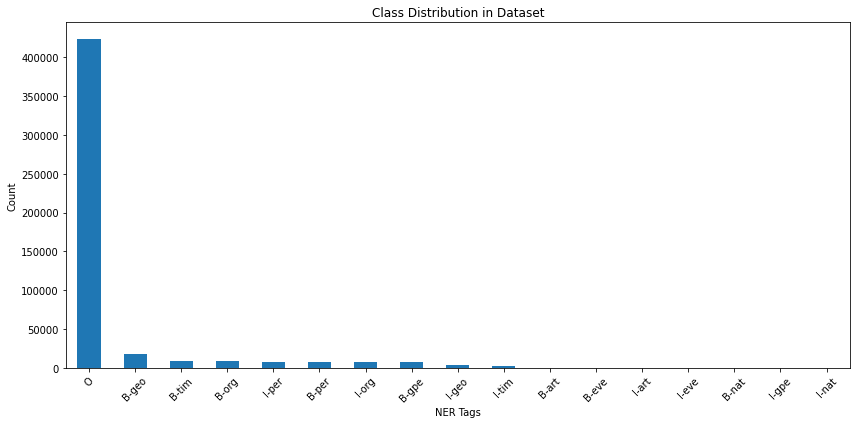

In [39]:
tag_counts = dataset['Tag'].value_counts()

plt.figure(figsize=(12, 6))
tag_counts.plot(kind='bar')
plt.title('Class Distribution in Dataset')
plt.xlabel('NER Tags')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Text encoding

Convert each word into subwords and their respective subword ids such that Bert can work with the words

<span>**modifications**</span>

- look up attention values by setting `output_attentions=True` - useful for explananibility later on

In [69]:
# tokenize words
PRETRAINED = "prajjwal1/bert-tiny"
tokenizer = BertTokenizerFast.from_pretrained(PRETRAINED, output_attentions=True) 
sentences_encoded = tokenizer(
    sentences, is_split_into_words=True, return_tensors="pt", padding=True, truncation=True, max_length=150, add_special_tokens=False
);

In [48]:
sentences_encoded["input_ids"].shape

torch.Size([22862, 150])

### Target encoding

Convert the NER tags into tensors such that Bert can work with them

In [70]:
# mapping from ner tag to number
tag2idx = {tag: i for i, tag in enumerate(set(t for ts in targets for t in ts))}
tag2idx

{'I-tim': 0,
 'I-gpe': 1,
 'I-org': 2,
 'I-per': 3,
 'B-org': 4,
 'I-nat': 5,
 'I-geo': 6,
 'O': 7,
 'B-tim': 8,
 'B-geo': 9,
 'B-gpe': 10,
 'B-nat': 11,
 'I-eve': 12,
 'B-art': 13,
 'I-art': 14,
 'B-per': 15,
 'B-eve': 16}

Pad the target tensors because sentences have different length

In [71]:
max_len = sentences_encoded["input_ids"].shape[1]
targets_encoded = torch.empty((0, max_len), dtype=torch.long)

for sent_idx, target in enumerate(targets):
    enc = torch.full(size=(max_len,), fill_value=tag2idx['O'], dtype=torch.long)
    # repeat ner tag for each subword
    for word_idx, tag in enumerate(target):
        span = sentences_encoded.word_to_tokens(sent_idx, word_idx)
        # ignore words that tokenizer did not understand e.g. special characters
        if span is not None:
            start, end = span
            enc[start:end] = tag2idx[tag]
    targets_encoded = torch.vstack((targets_encoded, enc))

targets_encoded.shape

torch.Size([22862, 150])

Show the first sample and its target tensor

In [72]:
tokenizer.decode(sentences_encoded["input_ids"][0])

'thousands of demonstrators have marched through london to protest the war in iraq and demand the withdrawal of british troops from that country. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [73]:
targets_encoded[:1]

tensor([[ 7,  7,  7,  7,  7,  7,  9,  7,  7,  7,  7,  7,  9,  7,  7,  7,  7,  7,
         10,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7]])

### Train/Test split

Split dataset into training and test set


<span style="color:red;">**modifications**</span>

In [74]:
train_size = int(0.8 * len(sentences_encoded.input_ids))
test_size = int(0.2 * len(sentences_encoded.input_ids))
train_sentences = sentences_encoded[:train_size]
train_targets = targets_encoded[:train_size]
test_sentences = sentences_encoded[train_size:train_size+test_size]
test_targets = targets_encoded[train_size:train_size+test_size]
(f"Train sentences: {len(train_targets)}", f"Test sentences: {len(test_targets)}")

('Train sentences: 18289', 'Test sentences: 4572')

In [75]:
class NERDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = sentences
        self.labels = labels

    def __getitem__(self, index):
        ids = torch.tensor(self.sentences[index].ids)
        mask = torch.tensor(self.sentences[index].attention_mask)
        labels = self.labels[index].clone()

        return {
            'ids': ids,
            'mask': mask,
            'tags': labels
        }

    def __len__(self):
        return len(self.labels)

training_set = NERDataset(train_sentences, train_targets)
testing_set = NERDataset(test_sentences, test_targets)

training_loader = DataLoader(training_set, batch_size=16, shuffle=True)
testing_loader = DataLoader(testing_set, batch_size=16, shuffle=True)

## Train model

Load a pretrained Bert model to fine-tune for multi-class classification of NER tags

<span style="color:red;">**modifications**</span>


- use numpy array of list for speed and resources optimization - look up here link why ()
- slit data into train/val/test
- use cross validation - if data is not much


In [95]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = BertForTokenClassification.from_pretrained(PRETRAINED, num_labels=len(tag2idx), output_attentions=True, output_hidden_states=True)
model = model.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-05)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from t

In [96]:
# training loop
for epoch in range(1, 3):
    epoch_train_losses = np.zeros(shape=len(training_loader))
    model.train()
    for i, data in enumerate(training_loader, 0):
        data = {k: v.to(device) for k, v in data.items()}
        output = model(data["ids"], attention_mask=data["mask"], labels=data["tags"])
        loss = output[0]
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_train_losses[i] = loss.detach().cpu().item()

   
    print(f"Epoch: {epoch} - train_loss: {epoch_train_losses.mean()}")

Epoch: 1 - train_loss: 0.4944019034127151
Epoch: 2 - train_loss: 0.13121548754495235


## Test model

Compute classification metric of Bert model on test set


<span style="color:red;">**modifications**</span>

In [94]:
from sklearn.metrics import accuracy_score

model.eval()
all_preds, all_trues = [], []

for data in testing_loader:
    data = {k: v.to(device) for k, v in data.items()}
    with torch.no_grad():
        output = model(data["ids"], attention_mask=data["mask"], labels=data["tags"])
    loss = output[0]
    logits = output[1].detach().cpu()
    mask = data["mask"].cpu()
    
    print(output.keys())
    
    label_ids = data["tags"].cpu()
    pred_ids = torch.argmax(logits, dim=-1)

    for i in range(pred_ids.shape[0]):
        # remove pad predictions
        pred_ids_non_pad = pred_ids[i, mask[i]]
        label_ids_non_pad = label_ids[i, mask[i]]
        all_preds.append(pred_ids_non_pad)
        all_trues.append(label_ids_non_pad)
    
    break

all_preds = torch.cat(all_preds)
all_trues = torch.cat(all_trues)
accuracy = accuracy_score(all_trues, all_preds)
print("Test Accuracy:", round(accuracy, 3))

odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_keys(['loss', 'logits'])
odict_ke

In [79]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(all_trues, all_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       171
           1       0.00      0.00      0.00        94
           2       0.00      0.00      0.00      1875
           3       0.07      0.36      0.12      2645
           4       0.00      0.00      0.00     37345
           5       0.00      0.00      0.00        16
           6       0.00      0.00      0.00       845
           7       0.95      0.99      0.97    490765
           8       0.00      0.00      0.00      8967
           9       0.28      0.94      0.43     47144
          10       0.00      0.00      0.00     41665
          11       0.00      0.00      0.00       267
          13       0.00      0.00      0.00       452
          14       0.00      0.00      0.00        11
          15       0.00      0.00      0.00     53275
          16       0.00      0.00      0.00       263

    accuracy                           0.78    685800
   macro avg       0.08   

In [82]:
tag2idx

{'I-tim': 0,
 'I-gpe': 1,
 'I-org': 2,
 'I-per': 3,
 'B-org': 4,
 'I-nat': 5,
 'I-geo': 6,
 'O': 7,
 'B-tim': 8,
 'B-geo': 9,
 'B-gpe': 10,
 'B-nat': 11,
 'I-eve': 12,
 'B-art': 13,
 'I-art': 14,
 'B-per': 15,
 'B-eve': 16}

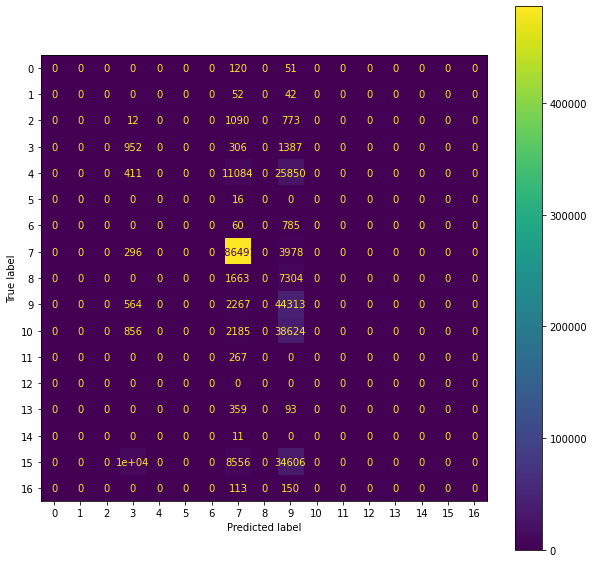

In [91]:
fig, ax = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(all_trues, all_preds, labels=list(tag2idx.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(tag2idx.values()))
disp.plot(ax=ax)
# plt.grid(None)
plt.show()

<h2> 
    <span style="color:red;">
        Model Explanability </span>
    </h2>


In [66]:
import eli5

2023-09-09 16:58:00.316027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-09 16:58:01.225709: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ionelia/.mujoco/mjpro150/bin
2023-09-09 16:58:01.225815: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ionelia/.mujoco/mjpro150/bin
2023-09-09 16:58:01.225823: W tensorflow/compiler/tf2tenso

In [68]:
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwis